#Improts

In [ ]:
#@title
import sys
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
import numpy as np
!git clone https://github.com/bosemessi/StatsbombOpenData --q
from tqdm import tqdm
import requests 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.mlab as mlab
import time
import json
import pandas as pd
import requests
from pandas import json_normalize
import os
import csv
pd.options.mode.chained_assignment = None
import seaborn as sns
!pip install scikit-plot --q
import scikitplot as skplt
import scipy  
from scipy.cluster import hierarchy as hc
from collections import defaultdict
!pip install rfpimp --q
from rfpimp import *

# Machine learning
from sklearn import preprocessing, model_selection, svm, metrics
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
 
from imblearn.over_sampling import SMOTENC


from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import brier_score_loss

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

fatal: destination path 'StatsbombOpenData' already exists and is not an empty directory.


#Read the WC Data file, extract open play passes, extract coordinates

In [ ]:
df = pd.read_parquet('/content/StatsbombOpenData/WC2018.parquet').reset_index(drop=True)

Df=df.query("(type_name == 'Pass')\
                   &(pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off'])")
Df[['x','y']] = np.array(list(Df.location))
Df[['endX','endY']] = np.array(list(Df.pass_end_location))
Df = Df.reset_index(drop=True)

#Feature engineering

In [ ]:
passes = Df.copy()
passes.loc[passes['pass_outcome_name'].isnull(),'success'] = 1
passes.loc[passes['pass_outcome_name'].notnull(), 'success'] = 0
passes['x_dist'] = passes['endX'] - passes['x'] + 1e-5
passes['y_dist'] = passes['endY'] - passes['y']
passes['distance'] = np.sqrt((passes['x_dist']**2 + passes['y_dist']**2))
passes['angle'] = np.abs(np.arctan2(passes['y_dist'],passes['x_dist']))
feature_cols = ['duration', 'angle', 'pass_body_part_name', 'x', 'y', 'endX','endY',
                'pass_cross', 'pass_cut_back', 'pass_deflected', 'pass_height_name', 'distance', 
                'pass_switch', 'pass_through_ball', 'play_pattern_name', 'under_pressure', 'success']
pass_final = passes[feature_cols]
bool_cols = ['pass_cross', 'pass_cut_back', 'pass_deflected','pass_switch', 'pass_through_ball','under_pressure']
for col in bool_cols:
    pass_final[col] = np.where(pass_final[col].isna(), 0, 1)
features = pass_final.drop('success', axis=1)
labels = pass_final['success']

In [ ]:
pass_final.head()

,duration,angle,pass_body_part_name,x,y,endX,endY,pass_cross,pass_cut_back,pass_deflected,pass_height_name,distance,pass_switch,pass_through_ball,play_pattern_name,under_pressure,success
0,2.947,0.248963,Right Foot,38.0,42.0,97.0,57.0,0,0,0,High Pass,60.876935,0,0,From Kick Off,1,0.0
1,2.293,0.358771,Head,24.0,24.0,48.0,33.0,0,0,0,High Pass,25.632021,0,0,From Kick Off,0,0.0
2,1.079,3.141593,Head,73.0,48.0,68.0,48.0,0,0,0,High Pass,4.999990,0,0,From Kick Off,0,1.0
3,1.467,0.404891,None,75.0,50.0,82.0,53.0,0,0,0,High Pass,7.615782,0,0,From Kick Off,1,0.0
4,1.613,0.211093,Head,39.0,28.0,53.0,31.0,0,0,0,High Pass,14.317831,0,0,From Kick Off,0,0.0


#Label-encoding the categorical columns

In [ ]:
cont_cols = ['duration', 'angle', 'distance','x', 'y', 'endX','endY'] 
cat_features = features.drop(cont_cols, axis=1)
cont_features = features[cont_cols]
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df.head(20).transpose())
def label_encode(df):
    # Convert df to label encoded
    df_le = pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)
    # Save mappings as a dict
    mappings = {col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
     for col in df}
    return df_le, mappings
cat_features_le, mappings = label_encode(cat_features)
features_le = cont_features.merge(cat_features_le, left_index=True, right_index=True)

#First try with a Random Forest

In [ ]:
X = features_le
y = labels
 
m = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
 
# Define a function to calculate the Brier loss using cross-validation
def get_loss(X, y=y, m=m, cv=cv):
    scores = cross_val_score(m, X, y, cv=cv, scoring='brier_score_loss')
    return np.mean(scores)*-1
 
loss = get_loss(X=X)
print('Brier loss:', "{0:.5f}".format(loss))

Brier loss: 0.08322


#Make a dendrogram for correlated features. 

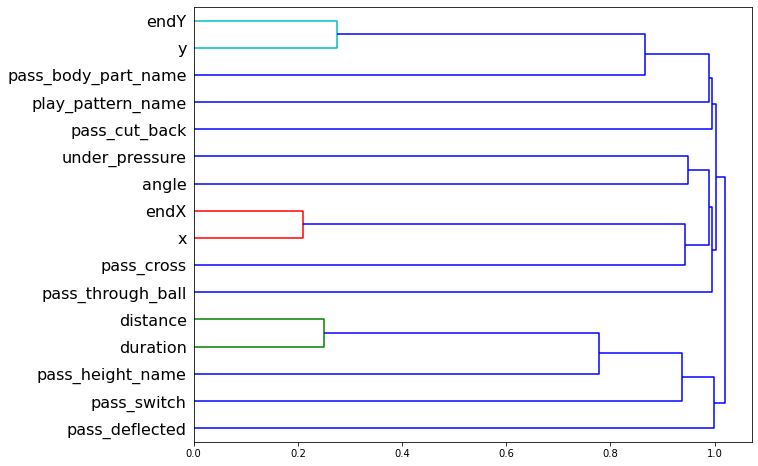

In [ ]:
from numpy.random import rand
from numpy.random import seed
seed(42)
copyX = X + rand(*X.shape) / 100000.0
def dendrogram(X):
    corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(10,8))
    dendrogram = hc.dendrogram(z, labels=X.columns, 
          orientation='right', leaf_font_size=16)
    plt.show()
    return
dendrogram(copyX)

#Remove the correlated features and check if the Brier loss reduces.

In [ ]:
feats = ['x', 'endX',
         'y', 'endY',
         'distance', 'duration']
print('original', "{0:.5f}".format(loss))
for feat in feats:
    loss_feats = get_loss(X=X.drop(feat, axis=1))   
    print(feat, "{0:.5f}".format(loss_feats))

original 0.08322
x 0.08325
endX 0.08439
y 0.08395
endY 0.08874
distance 0.08563
duration 0.08873


#Feature importance extraction

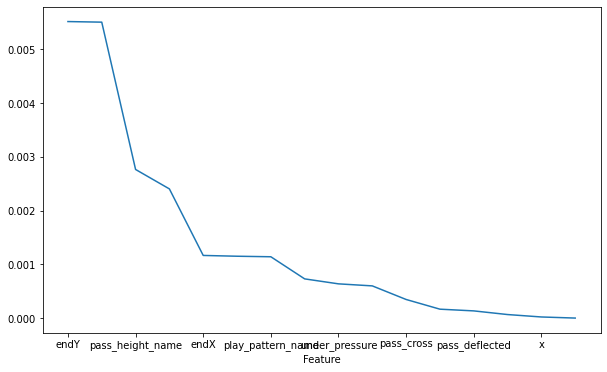

In [ ]:
## Define a function to get feature importance using the drop-column method
def get_imp(X, y=y, m=m, cv=cv):
    baseline = get_loss(X=X, y=y, m=m, cv=cv)
    imp = []
    for col in X.columns:
        s = get_loss(X=X.drop(col, axis=1), y=y, m=m, cv=cv)
        change_in_score = s - baseline
        imp.append(change_in_score)
    imp_df = pd.DataFrame(data={'Feature': X.columns, 'Importance': np.array(imp)})
    imp_df = imp_df.set_index('Feature').sort_values('Importance', ascending=False)
    return imp_df

imp1 = get_imp(X=X)
imp1.reset_index().plot('Feature', 'Importance', figsize=(10,6), legend=False);

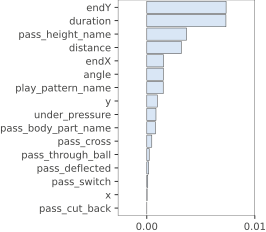

In [ ]:
plot_importances(imp1, imp_range=(min(imp1.values), max(imp1.values)))

#Drop the least 3 important features and check Brier loss again.

In [ ]:
X2 = X.drop(['x','pass_cut_back','pass_switch'], axis=1)
loss2 = get_loss(X=X2)
print('Brier loss:', "{0:.5f}".format(loss2))

Brier loss: 0.08298


#Improvement !! Ok...now do a train-test split. Then use an XGBClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.20, shuffle=True, stratify=y, random_state=42)

In [ ]:
%%time

xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

Brier loss: 0.08581
CPU times: user 21.1 s, sys: 19.4 ms, total: 21.1 s
Wall time: 10.8 s


#Do a grid search for the best choice of parameters.

In [ ]:
%%time
## Create the parameter grid
# # Define function to print the results of the grid search
def print_gs_results(gs, print_all=True):
    if print_all == True:
        print('Grid scores:')
        means = gs.cv_results_['mean_test_score']*-1
        stds = gs.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, gs.cv_results_['params']):
            print("%0.5f (+/-%0.05f) for %r"
                  % (mean, std * 2, params))
        print()
        print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
    else:
        print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
    return

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
params = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=5)],
    'max_depth': [i for i in range(3, 5)],
}

## Create the randomised grid search model
## See http://scikit-learn.sourceforge.net/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html
## "n_iter = number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution"
rgs = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=20, cv=cv, random_state=42, n_jobs=-1,
                         scoring='brier_score_loss', return_train_score=True)

# Fit rgs
rgs.fit(X_train, y_train)

# Print results
print_gs_results(gs=rgs, print_all=False)

Best: 0.07851 using {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.3}
CPU times: user 23.2 s, sys: 314 ms, total: 23.5 s
Wall time: 8min 37s


#Some tests of the model

In [ ]:
# Define a function to help fit models and print the results
def print_results(xgb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    # Fit model
    xgb.fit(X_train, y_train)
    
    # Get predicted probabilities
    y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]

    # Print results
    print('Actual passes:', sum(y_test))
    print('Predicted passes (xgb):', '{0:.2f}'.format(sum(y_pred_proba_xgb)))
    print('Brier loss (xgb):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_xgb)))
    return

# Evaluate best models on the hold-out set
best_xgb = rgs.best_estimator_

print_results(xgb=best_xgb)
print_results(xgb=xgb)

Actual passes: 9415.0
Predicted passes (xgb): 9395.48
Brier loss (xgb): 0.07578
Actual passes: 9415.0
Predicted passes (xgb): 9390.28
Brier loss (xgb): 0.08363


In [ ]:
calibrated_xgb = CalibratedClassifierCV(rgs.best_estimator_, cv=cv, method='sigmoid')
print_results(xgb=calibrated_xgb)

Actual passes: 9415.0
Predicted passes (xgb): 9386.61
Brier loss (xgb): 0.07712


In [ ]:
import pickle
filename = 'final_model2.sav'
pickle.dump(best_xgb, open(filename, 'wb'))

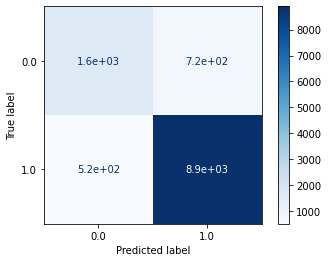

In [ ]:
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(best_xgb, X_test, y_test,
                                 cmap=plt.cm.Blues)

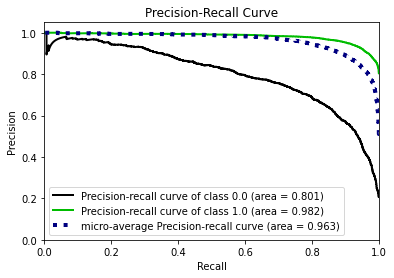

In [ ]:
skplt.metrics.plot_precision_recall(y_test, calibrated_xgb.predict_proba(X_test))

In [ ]:
len(X2),len(passes)

(58677, 58677)

#Fit the model to the entire dataset

In [ ]:
best_xgb.fit(X2, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
pass_final['xp'] = best_xgb.predict_proba(X2)[:,1]
pass_final['name'] = passes['player_name']
pass_final

,duration,angle,pass_body_part_name,x,y,endX,endY,pass_cross,pass_cut_back,pass_deflected,pass_height_name,distance,pass_switch,pass_through_ball,play_pattern_name,under_pressure,success,xp,name
0,2.947,0.248963,Right Foot,38.0,42.0,97.0,57.0,0,0,0,High Pass,60.876935,0,0,From Kick Off,1,0.0,0.170571,Mathias Jattah-Njie Jørgensen
1,2.293,0.358771,Head,24.0,24.0,48.0,33.0,0,0,0,High Pass,25.632021,0,0,From Kick Off,0,0.0,0.140532,Domagoj Vida
2,1.079,3.141593,Head,73.0,48.0,68.0,48.0,0,0,0,High Pass,4.999990,0,0,From Kick Off,0,1.0,0.801036,Thomas Delaney
3,1.467,0.404891,None,75.0,50.0,82.0,53.0,0,0,0,High Pass,7.615782,0,0,From Kick Off,1,0.0,0.139065,Andreas Christensen
4,1.613,0.211093,Head,39.0,28.0,53.0,31.0,0,0,0,High Pass,14.317831,0,0,From Kick Off,0,0.0,0.354692,Marcelo Brozović
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58672,3.790,0.221314,Left Foot,6.0,44.0,86.0,62.0,0,0,0,High Pass,82.000010,0,0,From Goal Kick,0,1.0,0.532106,Jordan Pickford
58673,0.733,0.708626,Head,87.0,60.0,94.0,66.0,0,0,0,High Pass,9.219552,0,0,From Goal Kick,0,0.0,0.620007,Harry Kane
58674,0.400,2.999695,Right Foot,20.0,5.0,13.0,4.0,0,0,0,Ground Pass,7.071058,0,0,From Throw In,1,1.0,0.894125,Mohamed Amine Ben Amor
58675,2.120,0.183111,Left Foot,13.0,4.0,40.0,9.0,0,0,0,High Pass,27.459070,0,0,From Throw In,0,0.0,0.174295,Ali Maâloul


#Groupby to get actual and expected pass success

In [ ]:
groupedstats = pass_final.groupby('name').agg({'duration':'count','success':'sum','xp':'sum'}).reset_index()
groupedstats.rename(columns={'duration':'Open Play Passes',
                             'success':'Successful Open Play Passes',
                             'xp':'Expected Pass Success'},inplace=True)
groupedstats

,name,Open Play Passes,Successful Open Play Passes,Expected Pass Success
0,Aaron Mooy,184,155.0,160.993301
1,Abdalla Mahmoud El Said Bekhit,138,105.0,109.137688
2,Abdiel Arroyo Molinar,5,4.0,3.102790
3,Abdullah Ibrahim Al Maiouf,29,13.0,16.288088
4,Abdullah Ibrahim Otayf,252,228.0,224.766037
...,...,...,...,...
595,İlkay Gündoğan,51,47.0,46.432709
596,Łukasz Fabiański,23,16.0,17.069645
597,Łukasz Piszczek,94,63.0,68.951218
598,Łukasz Teodorczyk,8,6.0,5.394203


#Define 'Pass Completed Above Expected', then mount google drive and save.

In [ ]:
groupedstats['Pass Completed Above Expected'] = groupedstats['Successful Open Play Passes']/groupedstats['Expected Pass Success']

In [ ]:
groupedstats

,name,Open Play Passes,Successful Open Play Passes,Expected Pass Success,Pass Completed Above Expected
0,Aaron Mooy,184,155.0,160.993301,0.962773
1,Abdalla Mahmoud El Said Bekhit,138,105.0,109.137688,0.962087
2,Abdiel Arroyo Molinar,5,4.0,3.102790,1.289162
3,Abdullah Ibrahim Al Maiouf,29,13.0,16.288088,0.798129
4,Abdullah Ibrahim Otayf,252,228.0,224.766037,1.014388
...,...,...,...,...,...
595,İlkay Gündoğan,51,47.0,46.432709,1.012217
596,Łukasz Fabiański,23,16.0,17.069645,0.937336
597,Łukasz Piszczek,94,63.0,68.951218,0.913689
598,Łukasz Teodorczyk,8,6.0,5.394203,1.112305


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
groupedstats.to_parquet('/content/drive/MyDrive/Norwich/xP.parquet',index=False)